In [1]:
import os
import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import wandb
# from pytorch_lightning import seed_everything
import clip

from logging import log

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

/home/ridwan.salahuddeen/.conda/envs/clipenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !unzip -o -q ../hateful_memes.zip -d $HOME/.cache/torch/mmf/data/datasets/
# !mkdir -p $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/{images,annotations,features/{train,test,val}}
# !mv  $HOME/.cache/torch/mmf/data/datasets/img $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/
# !mv $HOME/.cache/torch/mmf/data/datasets/*.jsonl $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/

In [3]:
class HMDataset(Dataset):
    def __init__(self, images_path: str, annotation_path: str, image_transform=None, text_transform=None) -> None:
        self.images_path = images_path
        self.annotation_path = annotation_path
        self.image_transform = image_transform
        self.text_transform = text_transform
        assert self.annotation_path.endswith(".jsonl"), f"Invalid annotation file format. Format should be '.jsonl', not {self.annotation_path.split('.')[0]}"
        self.annotation: pd.DataFrame = pd.read_json(self.annotation_path, lines=True)      

    def __len__(self):
        return self.annotation.shape[0]

    def __getitem__(self, index):
        img_path = os.path.join(self.images_path.split('img')[0], self.annotation.loc[index,"img"])
        image = Image.open(img_path).convert("RGB")
        text = self.annotation.loc[index,"text"]
        label = self.annotation.loc[index,"label"]
        if self.image_transform:
            image = self.image_transform(image)
        if self.text_transform:
            text = self.text_transform(text)
        return image, text, torch.tensor(label)

In [4]:
HOME = os.getenv("HOME")

In [6]:
model, preprocess = clip.load("ViT-L/14@336px")


In [7]:
train_dataset = HMDataset(
        f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/img/",
        os.path.join(f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/",'train_updated.jsonl'),
        image_transform=preprocess,
        text_transform=lambda texts: clip.tokenize(texts, truncate=True),
    )

In [18]:
memotion_dataset = HMDataset(
        f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/img/",
        os.path.join(f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/",'label_memotion.jsonl'),
        image_transform=preprocess,
        text_transform=lambda texts: clip.tokenize(texts, truncate=True),
    )

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=24)
memotion_dataloader = DataLoader(memotion_dataset, batch_size=64, shuffle=False, num_workers=24)

In [9]:
device = torch.device("cuda")

In [10]:
image_features, text_features = [], []
for i, data in  enumerate(train_dataloader):
    images, texts, labels = data
    images, texts, labels = images.to(device), texts.to(device), labels.to(device)
    with torch.no_grad():
        img_extract = model.encode_image(images)
        text_extract = model.encode_text(texts.squeeze())
    image_features.append(img_extract)
    text_features.append(text_extract)

In [20]:
m_image_features, m_text_features = [], []
m_labels_all = []
for i, data in  enumerate(memotion_dataloader):
    images, texts, labels = data
    images, texts, labels = images.to(device), texts.to(device), labels.to(device)
    with torch.no_grad():
        img_extract = model.encode_image(images)
        text_extract = model.encode_text(texts.squeeze())
    m_image_features.append(img_extract)
    m_text_features.append(text_extract)

In [34]:
m_labels_all = []
for i, data in  enumerate(memotion_dataloader):
    m_labels_all.append(data[-1])

labels_all = []
for i, data in  enumerate(train_dataloader):
    labels_all.append(data[-1])

In [14]:
# image_features = torch.vstack(image_features)
text_features = torch.vstack(text_features)

In [21]:
m_image_features = torch.vstack(m_image_features)
m_text_features = torch.vstack(m_text_features)

In [15]:
image_features = image_features.cpu().detach().numpy()
text_features = text_features.cpu().detach().numpy()

In [22]:
m_image_features = m_image_features.cpu().detach().numpy()
m_text_features = m_text_features.cpu().detach().numpy()

In [36]:
labels_all = torch.hstack(labels_all).cpu().detach().numpy()
m_labels_all = torch.hstack(m_labels_all).cpu().detach().numpy()

In [26]:
hmc = np.zeros(image_features.shape[0], dtype=str)
memo = np.zeros(m_image_features.shape[0], dtype=str)
hmc[:] = "hmc"
memo[:] = "memotion"
data_source = np.hstack([hmc, memo])

In [47]:
X_images = TSNE(n_components=2, learning_rate='auto',\
                  init='random', perplexity=3).\
                    fit_transform(np.vstack((image_features, m_image_features)))

In [ ]:
X_images_h = TSNE(n_components=3, learning_rate='auto',\
                  init='random', perplexity=3).fit_transform(image_features[labels_all==1])
m_X_images_h = TSNE(n_components=3, learning_rate='auto',\
                  init='random', perplexity=3).fit_transform(m_image_features[m_labels_all==1])
X_images_n = TSNE(n_components=3, learning_rate='auto',\
                  init='random', perplexity=3).fit_transform(image_features[labels_all==0])
m_X_images_n = TSNE(n_components=3, learning_rate='auto',\
                  init='random', perplexity=3).fit_transform(m_image_features[m_labels_all==0])

In [45]:
plt.plot()

(8928, 3)

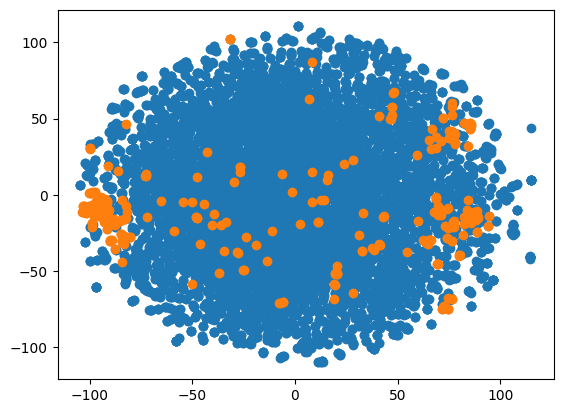

In [53]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(*X_images[:len(hmc)][labels].T,) # X_images[:len(hmc)], X_images[:len(hmc)])
ax.scatter(*X_images[len(hmc):].T,) # X_images[len(hmc):], X_images[len(hmc):])
# ax.scatter(X_images[:, 0], X_images[:, 1], X_images[:, 2])
# ax.scatter(X_images[:, 0], X_images[:, 1], X_images[:, 2])
plt.show()

In [51]:
data_source

array(['h', 'h', 'h', ..., 'm', 'm', 'm'], dtype='<U1')